In [5]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os 
from statsmodels.graphics.mosaicplot import mosaic
color = sns.color_palette()

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

#from library.sb_utils import save_file

import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('/content/instacart_data.csv')

In [7]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,112108,train,4,4,10,9.0,yogurt,dairy eggs
1,816049,49302,7,1,Bulgarian Yogurt,120,16,47901,train,14,4,6,16.0,yogurt,dairy eggs
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,2993,train,15,0,7,7.0,yogurt,dairy eggs
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,41425,train,4,3,8,14.0,yogurt,dairy eggs
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,187205,train,5,4,14,30.0,yogurt,dairy eggs


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40597 entries, 0 to 40596
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                40597 non-null  int64  
 1   product_id              40597 non-null  int64  
 2   add_to_cart_order       40597 non-null  int64  
 3   reordered               40597 non-null  int64  
 4   product_name            40597 non-null  object 
 5   aisle_id                40597 non-null  int64  
 6   department_id           40597 non-null  int64  
 7   user_id                 40597 non-null  int64  
 8   eval_set                40597 non-null  object 
 9   order_number            40597 non-null  int64  
 10  order_dow               40597 non-null  int64  
 11  order_hour_of_day       40597 non-null  int64  
 12  days_since_prior_order  40597 non-null  float64
 13  aisle                   40597 non-null  object 
 14  department              40597 non-null

In [9]:
# df = df['order_dow'].astype(object)

In [10]:
df.shape

(40597, 15)

In [11]:
dfo = df.select_dtypes(include=['object'])

In [12]:
dfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40597 entries, 0 to 40596
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  40597 non-null  object
 1   eval_set      40597 non-null  object
 2   aisle         40597 non-null  object
 3   department    40597 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


In [13]:
#Determine which categorical features should be transformed into indicator variables
dfo.product_name.nunique()

836

In [14]:
dfo.aisle.nunique()

1

In [15]:
dfo.department.nunique()


2

In [16]:
#dfo = dfo['department']

In [17]:
#order_dow (Order Day of the Week (Monday, Tuesday...Sunday) is a categorical value that is represented numerically.
#dfo['user_id']= df['user_id'].astype('category') #User_id crash RAM when converted to str, keep as numeric value rn.
dfo['order_dow']= df['order_dow'].astype('str')


In [18]:
#Implementing the assumption that order_dow '0' correlates to Sunday, as beginning of the week.
dfo['order_dow'].replace({'0':'Sunday', '1':'Monday','2':'Tuesday','3':'Wednesday', '4':'Thursday', '5':'Friday', '6':'Saturday'}, inplace=True)

In [19]:
dfo.drop(columns=['eval_set','aisle','product_name'], inplace=True)

In [20]:
dfo.head()

,department,order_dow
0,dairy eggs,Thursday
1,dairy eggs,Thursday
2,dairy eggs,Sunday
3,dairy eggs,Wednesday
4,dairy eggs,Thursday


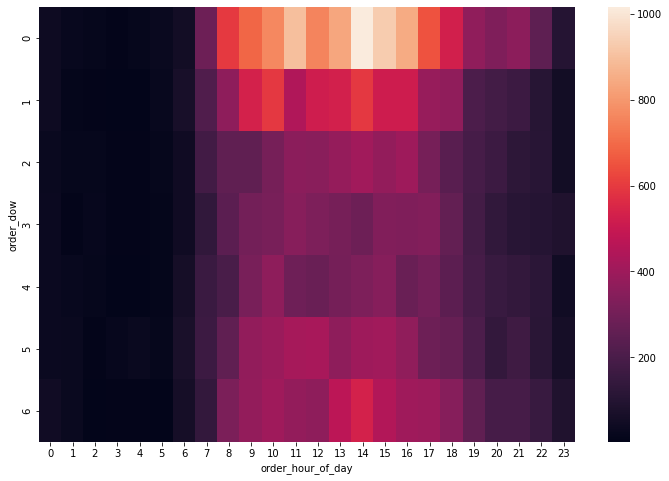

In [21]:
dow_hour_df = df.groupby(['order_dow','order_hour_of_day'])['order_number'].agg('count').reset_index()
dow_hour_df = dow_hour_df.pivot('order_dow','order_hour_of_day','order_number')

plt.figure(figsize=(12,8))
sns.heatmap(dow_hour_df)

`Department` will be the only categorical feature used in preprocessing. It has a relatively manageable count of unique variables (21). All other categorical variables have 100/1000+ nunique values. This would be exceptionally complex for this project.

In [22]:
dfo = pd.get_dummies(dfo)

In [23]:
df = pd.concat([df.drop(columns=['department', 'order_dow', 'eval_set', 'product_name'], axis=1), dfo], axis=1)

In [24]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_hour_of_day,days_since_prior_order,aisle,department_da,department_dairy eggs,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday
0,1,49302,1,1,120,16,112108,4,10,9.0,yogurt,0,1,0,0,0,0,1,0,0
1,816049,49302,7,1,120,16,47901,14,6,16.0,yogurt,0,1,0,0,0,0,1,0,0
2,1242203,49302,1,1,120,16,2993,15,7,7.0,yogurt,0,1,0,0,0,1,0,0,0
3,1383349,49302,11,1,120,16,41425,4,8,14.0,yogurt,0,1,0,0,0,0,0,0,1
4,1787378,49302,8,0,120,16,187205,5,14,30.0,yogurt,0,1,0,0,0,0,1,0,0


In [25]:
#Convert "Order_hour_of_day" into a datetime feature
t = pd.to_datetime(df['order_hour_of_day'], format='%H').dt.strftime('%H:%M')
t

0        10:00
1        06:00
2        07:00
3        08:00
4        14:00
         ...  
40592    16:00
40593    08:00
40594    11:00
40595    11:00
40596    17:00
Name: order_hour_of_day, Length: 40597, dtype: object

In [26]:
df['order_hour_of_day'] = t

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40597 entries, 0 to 40596
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                40597 non-null  int64  
 1   product_id              40597 non-null  int64  
 2   add_to_cart_order       40597 non-null  int64  
 3   reordered               40597 non-null  int64  
 4   aisle_id                40597 non-null  int64  
 5   department_id           40597 non-null  int64  
 6   user_id                 40597 non-null  int64  
 7   order_number            40597 non-null  int64  
 8   order_hour_of_day       40597 non-null  object 
 9   days_since_prior_order  40597 non-null  float64
 10  aisle                   40597 non-null  object 
 11  department_da           40597 non-null  uint8  
 12  department_dairy eggs   40597 non-null  uint8  
 13  order_dow_Friday        40597 non-null  uint8  
 14  order_dow_Monday        40597 non-null

In [28]:
df.order_number.nunique()

97

In [29]:
dfn = df.select_dtypes(include=['int','float64'])
dfn

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,days_since_prior_order
0,1,49302,1,1,120,16,112108,4,9.0
1,816049,49302,7,1,120,16,47901,14,16.0
2,1242203,49302,1,1,120,16,2993,15,7.0
3,1383349,49302,11,1,120,16,41425,4,14.0
4,1787378,49302,8,0,120,16,187205,5,30.0
...,...,...,...,...,...,...,...,...,...
40592,174863,42598,13,1,120,16,89101,20,2.0
40593,276222,18725,5,1,120,16,94523,4,23.0
40594,329275,17630,1,1,120,16,99315,5,17.0
40595,329275,19354,2,1,120,16,99315,5,17.0


Standardize numeric values due to significant difference in value range. 

In [30]:
dfn.drop(columns=['order_id','product_id','aisle_id','department_id', 'user_id'], inplace=True)
dfn

,add_to_cart_order,reordered,order_number,days_since_prior_order
0,1,1,4,9.0
1,7,1,14,16.0
2,1,1,15,7.0
3,11,1,4,14.0
4,8,0,5,30.0
...,...,...,...,...
40592,13,1,20,2.0
40593,5,1,4,23.0
40594,1,1,5,17.0
40595,2,1,5,17.0


In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
data_scaled = scaler.fit_transform(dfn)
data_scaled

array([[-1.08860315,  0.65872221, -0.82177384, -0.74671012],
       [-0.27399183,  0.65872221, -0.26319152, -0.06276095],
       [-1.08860315,  0.65872221, -0.20733329, -0.94212418],
       ...,
       [-1.08860315,  0.65872221, -0.7659156 ,  0.03494608],
       [-0.9528346 ,  0.65872221, -0.7659156 ,  0.03494608],
       [-1.08860315,  0.65872221,  1.85942129, -1.33295228]])

In [38]:
dfn = pd.DataFrame(data_scaled, columns=['add_to_cart_order','reordered','order_number','days_since_prior_order'])

In [41]:
df = pd.concat([df.drop(columns=['add_to_cart_order','reordered','order_number','days_since_prior_order'], axis=1), dfn], axis=1)
df

,order_id,product_id,aisle_id,department_id,user_id,order_hour_of_day,aisle,department_da,department_dairy eggs,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday,add_to_cart_order,reordered,order_number,days_since_prior_order
0,1,49302,120,16,112108,10:00,yogurt,0,1,0,0,0,0,1,0,0,-1.088603,0.658722,-0.821774,-0.746710
1,816049,49302,120,16,47901,06:00,yogurt,0,1,0,0,0,0,1,0,0,-0.273992,0.658722,-0.263192,-0.062761
2,1242203,49302,120,16,2993,07:00,yogurt,0,1,0,0,0,1,0,0,0,-1.088603,0.658722,-0.207333,-0.942124
3,1383349,49302,120,16,41425,08:00,yogurt,0,1,0,0,0,0,0,0,1,0.269082,0.658722,-0.821774,-0.258175
4,1787378,49302,120,16,187205,14:00,yogurt,0,1,0,0,0,0,1,0,0,-0.138223,-1.518091,-0.765916,1.305137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40592,174863,42598,120,16,89101,16:00,yogurt,0,1,1,0,0,0,0,0,0,0.540620,0.658722,0.071958,-1.430659
40593,276222,18725,120,16,94523,08:00,yogurt,0,1,0,0,1,0,0,0,0,-0.545529,0.658722,-0.821774,0.621188
40594,329275,17630,120,16,99315,11:00,yogurt,0,1,0,0,0,0,0,1,0,-1.088603,0.658722,-0.765916,0.034946
40595,329275,19354,120,16,99315,11:00,yogurt,0,1,0,0,0,0,0,1,0,-0.952835,0.658722,-0.765916,0.034946
